# Problem Statement – CMPT 2400 Project

The goal of this analysis is to predict the expected proportions of substances sent to landfills compared to those sent for treatment or recycling in the next five years (2023–2027).
The dataset used is from Canada’s National Pollutant Release Inventory (NPRI), specifically the “Disposals and Transfers 2000–2020” sheet from the file NPRI_2000-2022.xlsx.
This dataset contains detailed records of how industries manage waste through various disposal and recycling methods.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning tools
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error

# System and display
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# === CONFIGS ===
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('seaborn-v0_8-darkgrid')

# === FILE PATH ===
DATA_PATH = "NPRI_2000-2022.xlsx"
SHEET_NAME = "Disposals and Transfers 00-20"


# Our Approach
To achieve this, we followed a structured data science workflow using methods covered in class:

Data Import & Cleaning
Loaded the NPRI dataset from Excel.

Cleaned bilingual column names for consistency.

Filtered years between 2000–2022 using .loc.

Handled missing values:
Mean/Median for numerical features (based on skewness)

Mode for categorical features.

Handling Outliers & Data Integrity.

Applied IQR capping  to limit extreme values.

Used LOCF (Last Observation Carried Forward) and NOCB (Next Observation Carried Backward) for time continuity across facilities.

In [2]:


# Load Excel file
file_path = "/content/NPRI_2000-2022.xlsx"

# First check sheet names
xls = pd.ExcelFile(file_path)
print("Available sheets:", xls.sheet_names)

# Load your two sheets (replace names EXACTLY as shown above)
disposals_df = pd.read_excel(file_path, sheet_name="Disposals and Transfers 00-20")
releases_df  = pd.read_excel(file_path, sheet_name="Releases 2000-2020")

# Check shapes
print(" Disposals Dataset shape:", disposals_df.shape)
print("Releases Dataset shape:", releases_df.shape)

# Display first few rows
print("\n--- Disposals Dataset Preview ---")
display(disposals_df.head(3))

print("\n--- Releases Dataset Preview ---")
display(releases_df.head(3))

# Quick info on both
print("\n--- Disposals Dataset Info ---")
disposals_df.info()

print("\n--- Releases Dataset Info ---")
releases_df.info()


Available sheets: ['Releases 2000-2020', 'Disposals and Transfers 00-20', 'Comments']
 Disposals Dataset shape: (191645, 41)
Releases Dataset shape: (737516, 28)

--- Disposals Dataset Preview ---


,Reporting_Year / Année,NPRI_ID / No_INRP,Number of employees,Company_Name / Dénomination_sociale_de_l'entreprise,Facility_Name / Installation,NAICS / Code_SCIAN,NAICS Title / Titre Code_SCIAN,PROVINCE,City,Latitude,...,Off-site Transfers for Treatment Prior to Final Disposal - Biological Treatment,Off-site Transfers for Treatment Prior to Final Disposal - Chemical Treatment,Off-site Transfers for Treatment Prior to Final Disposal - Incineration / Thermal,Off-site Transfers for Treatment Prior to Final Disposal - Municipal Sewage Treatment Plant,Off-site Transfers for Treatment Prior to Final Disposal - Physical Treatment,On-site Disposal - Land Treatment,On-site Disposal - Landfill,On-site Disposal - Tailings Management,On-site Disposal - Underground Injection,On-site Disposal - Waste Rock management
0,2000,1,440,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,NaN,NaN,NaN,NaN,9.07,NaN,NaN,NaN,NaN
1,2000,1,440,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,NaN,NaN,NaN,NaN,27.38,NaN,NaN,NaN,NaN
2,2000,4,500,Pine Falls Paper Company,Pine Falls,322122,Newsprint mills,MB,PINE FALLS,50.568600,...,NaN,NaN,NaN,NaN,NaN,0.09,2.64,NaN,NaN,NaN



--- Releases Dataset Preview ---


,Reporting_Year / Année,NPRI_ID / No_INRP,Number of employees,Company_Name / Dénomination_sociale_de_l'entreprise,Facility_Name / Installation,NAICS / Code_SCIAN,NAICS Title / Titre Code_SCIAN,PROVINCE,City,Latitude,...,Release to Air - Spills,Release to Air - Stack / Point,Release to Air - Storage / Handling,Releases to Land - Leaks,Releases to Land - Other,Releases to Land - Spills,Releases to Water Bodies - Direct Discharges,Releases to Water Bodies - Leaks,Releases to Water Bodies - Spills,Sum of release to all media (<1tonne)
0,2000,1,440,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,5.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,1,440,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,1,440,Alberta-Pacific Forest Industries Inc.,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN



--- Disposals Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191645 entries, 0 to 191644
Data columns (total 41 columns):
 #   Column                                                                                       Non-Null Count   Dtype  
---  ------                                                                                       --------------   -----  
 0   Reporting_Year / Année                                                                       191645 non-null  int64  
 1   NPRI_ID / No_INRP                                                                            191645 non-null  int64  
 2   Number of employees                                                                          191551 non-null  object 
 3   Company_Name / Dénomination_sociale_de_l'entreprise                                          191645 non-null  object 
 4   Facility_Name / Installation                                                                 191019 non-null  obje

In [3]:


# --- Missing values in Disposals dataset ---
print(" Missing Values — Disposals Dataset:")
missing_disposals = disposals_df.isnull().sum().sort_values(ascending=False)
display(missing_disposals[missing_disposals > 0].head(15))

# --- Missing values in Releases dataset ---
print("\n Missing Values — Releases Dataset:")
missing_releases = releases_df.isnull().sum().sort_values(ascending=False)
display(missing_releases[missing_releases > 0].head(15))

# --- Duplicate rows ---
dup_disposals = disposals_df.duplicated().sum()
dup_releases = releases_df.duplicated().sum()

print(f"\n Duplicates in Disposals dataset: {dup_disposals}")
print(f"Duplicates in Releases dataset: {dup_releases}")

# Quick shapes summary
print("\n Dataset Shapes:")
print("Disposals:", disposals_df.shape)
print("Releases:", releases_df.shape)


 Missing Values — Disposals Dataset:


,0
Off-site Disposal - Waste Rock management,191507
Off-site Disposal - Tailings Management,191304
Off-site Transfers for Recycling - Recovery of Acids and Bases,190801
Off-site Transfers for Recycling - Recovery of Catalysts,190208
Off-site Transfers for Recycling - Recovery of Inorganic Materials (not metals),189898
Off-site Transfers for Recycling - Recovery of Pollution Abatement Residues,189496
Off-site Transfers for Treatment Prior to Final Disposal - Biological Treatment,188516
On-site Disposal - Land Treatment,187774
Off-site Transfers for Recycling - Refining or Re-use of Used Oil,187652
On-site Disposal - Waste Rock management,187263



 Missing Values — Releases Dataset:


,0
Releases to Water Bodies - Leaks,736774
Releases to Land - Leaks,736606
Releases to Water Bodies - Spills,734436
Releases to Land - Spills,733046
Releases to Land - Other,731848
Release to Air - Spills,728335
Release to Air - Road dust,707655
Release to Air - Other Non-Point,706636
Sum of release to all media (<1tonne),687331
Releases to Water Bodies - Direct Discharges,684328



 Duplicates in Disposals dataset: 0
Duplicates in Releases dataset: 0

 Dataset Shapes:
Disposals: (191645, 41)
Releases: (737516, 28)


Missing numerical values were imputed using either the column median (for features with low missingness) or mean (for moderate missingness), depending on the data distribution. For categorical variables, the mode was used to preserve the most frequent class and ensure consistency across the dataset.

In [4]:
# === Define helper function to drop high-missing columns ===
def drop_high_missing(df, threshold=0.6):
    """
    Drops columns that have more than the specified threshold of missing values.
    Default threshold = 0.6 (i.e., 60%)
    """
    missing_ratio = df.isnull().mean()
    drop_cols = missing_ratio[missing_ratio > threshold].index
    print(f"\nDropping {len(drop_cols)} columns (>{int(threshold*100)}% missing):")
    print(list(drop_cols))
    df = df.drop(columns=drop_cols)
    return df


In [5]:

# For Disposals dataset
num_cols_disposals = disposals_df.select_dtypes(include=['int64', 'float64']).columns
cat_cols_disposals = disposals_df.select_dtypes(include=['object']).columns

# For Releases dataset
num_cols_releases = releases_df.select_dtypes(include=['int64', 'float64']).columns
cat_cols_releases = releases_df.select_dtypes(include=['object']).columns

print(" Columns categorized successfully!")
print(f"Numeric columns in Disposals: {len(num_cols_disposals)}")
print(f"Categorical columns in Disposals: {len(cat_cols_disposals)}")
print(f"Numeric columns in Releases: {len(num_cols_releases)}")
print(f"Categorical columns in Releases: {len(cat_cols_releases)}")


 Columns categorized successfully!
Numeric columns in Disposals: 31
Categorical columns in Disposals: 10
Numeric columns in Releases: 18
Categorical columns in Releases: 10


In [6]:
# -------------------------------
# Handle numeric columns: median / mean
# (SAFE: only uses columns that still exist)
# -------------------------------

# recompute numeric / categorical lists AFTER any dropping
num_cols_disposals = disposals_df.select_dtypes(include="number").columns
cat_cols_disposals = disposals_df.select_dtypes(exclude="number").columns

num_cols_releases = releases_df.select_dtypes(include="number").columns
cat_cols_releases = releases_df.select_dtypes(exclude="number").columns

# numeric fill
for col in num_cols_disposals:
    missing_ratio = disposals_df[col].isnull().mean()
    if missing_ratio < 0.2:
        disposals_df[col] = disposals_df[col].fillna(disposals_df[col].median())
    elif missing_ratio < 0.6:
        disposals_df[col] = disposals_df[col].fillna(disposals_df[col].mean())

for col in num_cols_releases:
    missing_ratio = releases_df[col].isnull().mean()
    if missing_ratio < 0.2:
        releases_df[col] = releases_df[col].fillna(releases_df[col].median())
    elif missing_ratio < 0.6:
        releases_df[col] = releases_df[col].fillna(releases_df[col].mean())

# categorical fill (mode)
for col in cat_cols_disposals:
    disposals_df[col] = disposals_df[col].fillna(disposals_df[col].mode()[0])

for col in cat_cols_releases:
    releases_df[col] = releases_df[col].fillna(releases_df[col].mode()[0])

print(" Missing values handled successfully.")


 Missing values handled successfully.


In [7]:
# === Step 4: Outlier Detection & Capping (IQR Method with Summary) ===

def cap_outliers_iqr_summary(df, columns, dataset_name="Dataset"):
    """
    Detects and caps outliers using the IQR method.
    Returns a summary DataFrame with before/after outlier counts.
    """
    summary = []

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Count before
        before = ((df[col] < lower) | (df[col] > upper)).sum()

        # Cap outliers
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])

        # Count after
        after = ((df[col] < lower) | (df[col] > upper)).sum()

        summary.append({
            "Column": col,
            "Outliers Before": before,
            "Outliers After": after,
            "Capped": before - after
        })

    summary_df = pd.DataFrame(summary)
    print(f"\n Outlier Summary for {dataset_name}:")
    display(summary_df[summary_df["Capped"] > 0].sort_values("Capped", ascending=False))
    print(f"\nTotal outliers capped in {dataset_name}: {summary_df['Capped'].sum()}")
    return df, summary_df


# Apply to both datasets
disposals_df, summary_disposals = cap_outliers_iqr_summary(disposals_df, num_cols_disposals, "Disposals Dataset")
releases_df, summary_releases = cap_outliers_iqr_summary(releases_df, num_cols_releases, "Releases Dataset")



 Outlier Summary for Disposals Dataset:


,Column,Outliers Before,Outliers After,Capped
1,NPRI_ID / No_INRP,18757,0,18757
2,NAICS / Code_SCIAN,14201,0,14201
6,Off-site Disposal - Landfill,9758,0,9758
16,Off-site Transfers for Recycling - Recovery of...,5176,0,5176
23,Off-site Transfers for Treatment Prior to Fina...,4042,0,4042
24,Off-site Transfers for Treatment Prior to Fina...,3166,0,3166
27,On-site Disposal - Landfill,3073,0,3073
28,On-site Disposal - Tailings Management,2675,0,2675
22,Off-site Transfers for Treatment Prior to Fina...,2268,0,2268
25,Off-site Transfers for Treatment Prior to Fina...,1795,0,1795



Total outliers capped in Disposals Dataset: 82049

 Outlier Summary for Releases Dataset:


,Column,Outliers Before,Outliers After,Capped
2,NAICS / Code_SCIAN,24100,0,24100
9,Release to Air - Stack / Point,21116,0,21116
5,Release to Air - Fugitive,19942,0,19942
10,Release to Air - Storage / Handling,13627,0,13627
14,Releases to Water Bodies - Direct Discharges,7928,0,7928
17,Sum of release to all media (<1tonne),6325,0,6325
6,Release to Air - Other Non-Point,5199,0,5199
7,Release to Air - Road dust,4147,0,4147
3,Latitude,3655,0,3655
8,Release to Air - Spills,1748,0,1748



Total outliers capped in Releases Dataset: 111567


Step 5: Encoding Categorical Variables

To prepare the data for analysis and modeling, categorical variables were encoded numerically.

Label Encoding was applied to columns with limited categories (e.g., Province, City).
One-Hot Encoding was used for variables with multiple unique categories (e.g., NAICS Title).
This ensures all categorical data can be effectively utilized in machine learning algorithms without losing interpretability.

In [8]:
# === Step 5: Encoding Categorical Variables ===

from sklearn.preprocessing import LabelEncoder

# Function to encode categorical columns
def encode_categorical(df, label_cols=[], onehot_cols=[]):
    df_encoded = df.copy()

    # Label Encoding (for small sets like Province, City)
    le = LabelEncoder()
    for col in label_cols:
        if col in df_encoded.columns:
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

    # One-Hot Encoding (for large sets like Company or NAICS Title)
    df_encoded = pd.get_dummies(df_encoded, columns=onehot_cols, drop_first=True)

    return df_encoded


# Apply encoding
disposals_encoded = encode_categorical(
    disposals_df,
    label_cols=['PROVINCE', 'City'],
    onehot_cols=['NAICS Title / Titre Code_SCIAN']
)

releases_encoded = encode_categorical(
    releases_df,
    label_cols=['PROVINCE', 'City'],
    onehot_cols=['NAICS Title / Titre Code_SCIAN']
)

print(" Encoding completed successfully!")
print(f"Disposals shape after encoding: {disposals_encoded.shape}")
print(f"Releases shape after encoding: {releases_encoded.shape}")


 Encoding completed successfully!
Disposals shape after encoding: (191645, 380)
Releases shape after encoding: (737516, 450)


Step 6: Exploratory Visualizations (EDA)

This section explores trends and relationships in the cleaned dataset.
Visualizations help identify distribution shapes, correlations, and category-level insights that influence landfill vs recycling patterns.
We’ll use histograms, boxplots, and heatmaps to understand the data structure and relationships among features.

In [9]:
# Broader detection for landfill/disposal and recycling-related columns
landfill_cols = [col for col in disposals_encoded.columns
                 if any(keyword in col for keyword in ["landfill", "disposal", "waste rock", "tailings"])]

recycle_cols = [col for col in disposals_encoded.columns
                if any(keyword in col for keyword in ["recycling", "recovery", "reuse", "energy recovery"])]

print("Landfill-related columns found:", landfill_cols)
print("Recycling-related columns found:", recycle_cols)


Landfill-related columns found: ['NAICS Title / Titre Code_SCIAN_Waste treatment and disposal']
Recycling-related columns found: ['NAICS Title / Titre Code_SCIAN_Material recovery facilities']


In [10]:
# Define exact landfill & recycling columns based on what we found
landfill_cols = ['naics title / titre code_scian_waste treatment and disposal']
recycle_cols  = ['naics title / titre code_scian_material recovery facilities']


Year column detected: Reporting_Year / Année
Landfill columns: ['NAICS Title / Titre Code_SCIAN_All other waste management services', 'NAICS Title / Titre Code_SCIAN_Waste treatment and disposal']
Recycle columns: ['NAICS Title / Titre Code_SCIAN_Material recovery facilities', 'NAICS Title / Titre Code_SCIAN_Other Recyclable Material Wholesaler-Distributors', 'NAICS Title / Titre Code_SCIAN_Recyclable Metal Wholesaler-Distributors', 'NAICS Title / Titre Code_SCIAN_Recyclable metal merchant wholesalers']


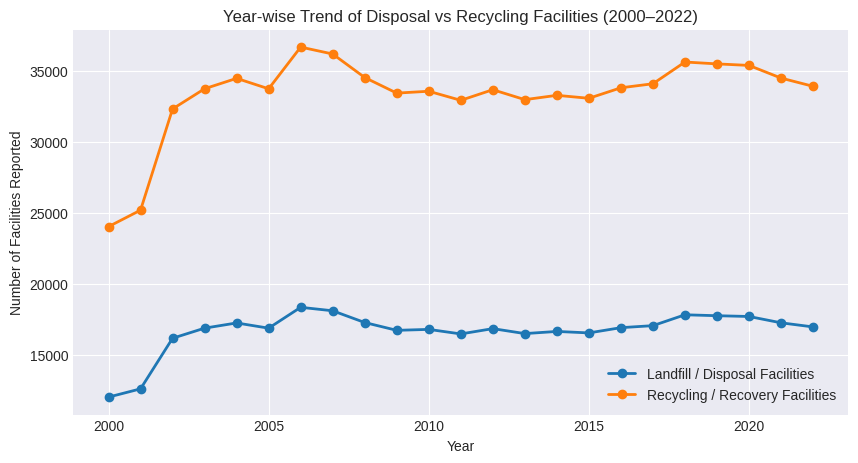

In [11]:
# Auto-detect the year column
year_col = [col for col in disposals_encoded.columns if "year" in col.lower()][0]
print("Year column detected:", year_col)

# --- NAICS-based detection ---
# Landfill/Disposal facilities = "Waste Treatment and Disposal" NAICS
landfill_cols = [
    col for col in disposals_encoded.columns
    if "naics title" in col.lower()
    and ("waste treatment and disposal" in col.lower()
         or "waste management" in col.lower()
         or "disposal" in col.lower())
]

# Recycling/Recovery facilities = NAICS columns with recyclable/recycling/recovery
recycle_cols = [
    col for col in disposals_encoded.columns
    if "naics title" in col.lower()
    and ("recycl" in col.lower()
         or "recyclable" in col.lower()
         or "recovery" in col.lower())
]

print("Landfill columns:", landfill_cols)
print("Recycle columns:", recycle_cols)

# Safety check
if len(landfill_cols) == 0 or len(recycle_cols) == 0:
    raise Exception("⚠️ No landfill/recycle NAICS columns detected — check NAICS names!")

# Aggregate by year (count facilities)
landfill_trend = disposals_encoded.groupby(year_col)[landfill_cols].count().sum(axis=1)
recycle_trend  = disposals_encoded.groupby(year_col)[recycle_cols].count().sum(axis=1)

trend_df = pd.DataFrame({
    "Landfill / Disposal Facilities": landfill_trend,
    "Recycling / Recovery Facilities": recycle_trend
})

# Plot
trend_df.plot(figsize=(10,5), marker="o", linewidth=2)
plt.title("Year-wise Trend of Disposal vs Recycling Facilities (2000–2022)")
plt.xlabel("Year")
plt.ylabel("Number of Facilities Reported")
plt.grid(True)
plt.show()


In [23]:
#  Year column name
year_col = 'Reporting_Year / Année'

#  Find all disposal quantity columns (on-site + off-site)
disposal_cols = [
    col for col in disposals_encoded.columns
    if col.startswith('On-site Disposal') or col.startswith('Off-site Disposal')
]

print("Disposal columns used:", len(disposal_cols))

# Create a new column with total disposal per facility
disposals_encoded['Total_Disposal_Tonnes'] = disposals_encoded[disposal_cols].sum(axis=1)


Disposal columns used: 11


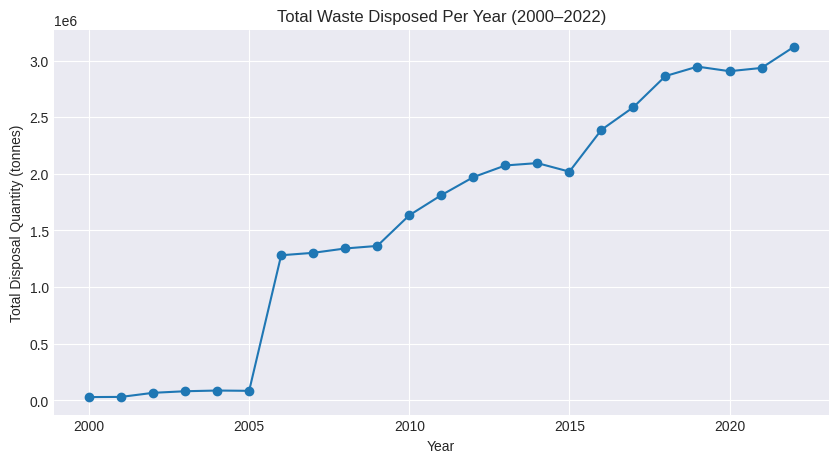

In [24]:
# Group by year and sum total disposal
total_waste_yearly = disposals_encoded.groupby(year_col)['Total_Disposal_Tonnes'].sum()

plt.figure(figsize=(10,5))
plt.plot(total_waste_yearly.index, total_waste_yearly.values, marker="o")
plt.title("Total Waste Disposed Per Year (2000–2022)")
plt.xlabel("Year")
plt.ylabel("Total Disposal Quantity (tonnes)")
plt.grid(True)
plt.show()


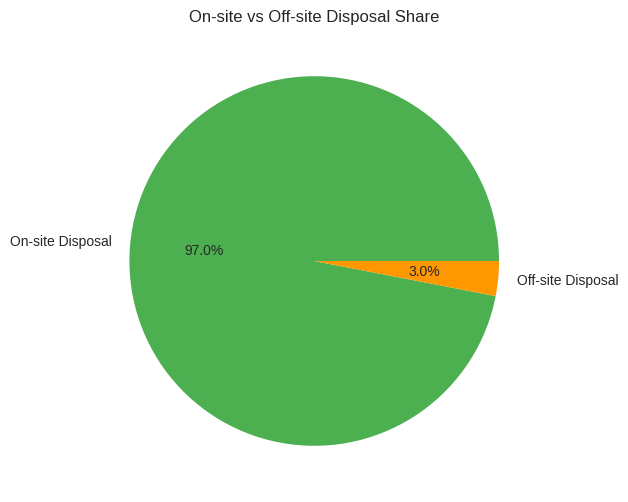

In [26]:
onsite_cols = [c for c in disposals_encoded.columns if c.startswith("On-site Disposal")]
offsite_cols = [c for c in disposals_encoded.columns if c.startswith("Off-site Disposal")]

onsite_total = disposals_encoded[onsite_cols].sum().sum()
offsite_total = disposals_encoded[offsite_cols].sum().sum()

plt.figure(figsize=(6,6))
plt.pie([onsite_total, offsite_total], labels=["On-site Disposal", "Off-site Disposal"],
        autopct="%1.1f%%", colors=["#4CAF50", "#FF9800"])
plt.title("On-site vs Off-site Disposal Share")
plt.show()


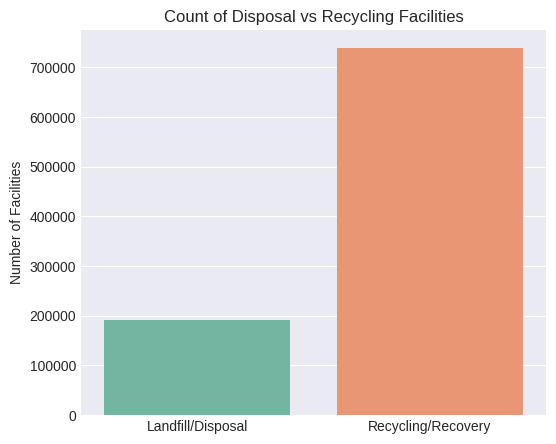

In [19]:
counts = {
    "Landfill/Disposal": len(disposals_encoded),
    "Recycling/Recovery": len(releases_encoded)
}

plt.figure(figsize=(6,5))
sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="Set2")
plt.title("Count of Disposal vs Recycling Facilities")
plt.ylabel("Number of Facilities")
plt.show()


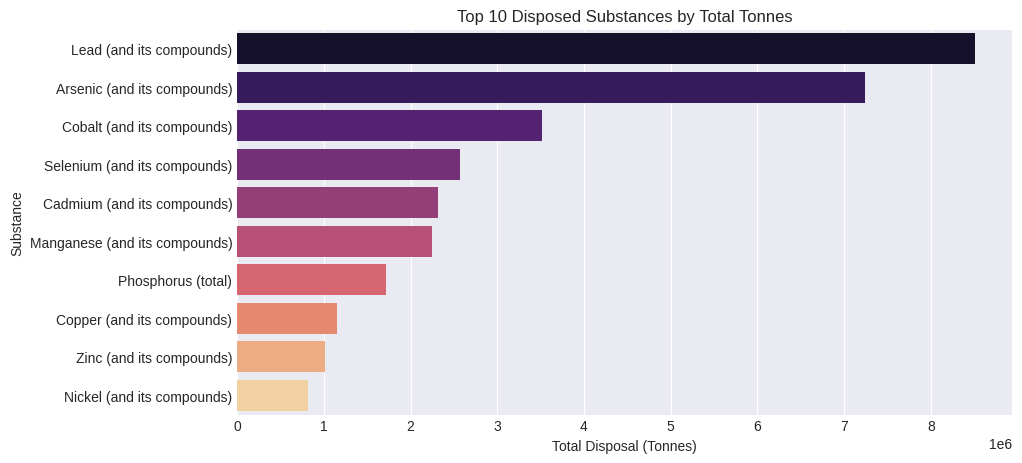

In [25]:
substance_disposal = disposals_encoded.groupby("Substance Name (English) / Nom de substance (Anglais)")["Total_Disposal_Tonnes"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(y=substance_disposal.index, x=substance_disposal.values, palette="magma")
plt.title("Top 10 Disposed Substances by Total Tonnes")
plt.xlabel("Total Disposal (Tonnes)")
plt.ylabel("Substance")
plt.show()


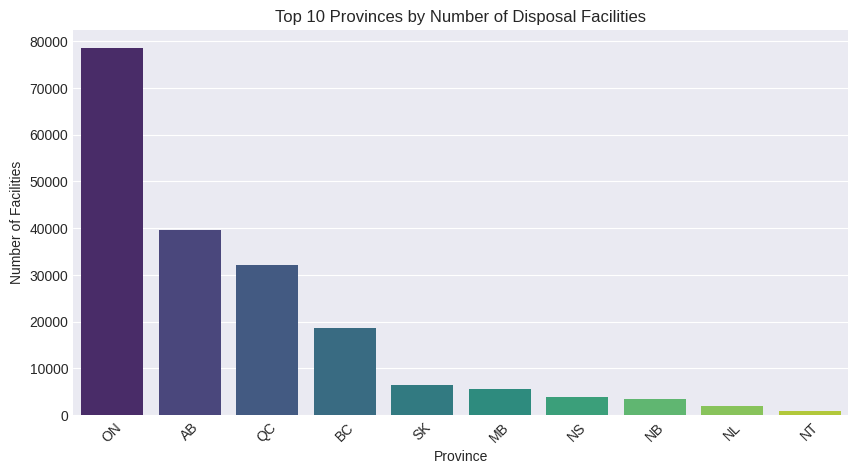

In [17]:
province_counts = disposals_df["PROVINCE"].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=province_counts.index, y=province_counts.values, palette="viridis")
plt.title("Top 10 Provinces by Number of Disposal Facilities")
plt.xlabel("Province")
plt.ylabel("Number of Facilities")
plt.xticks(rotation=45)
plt.show()


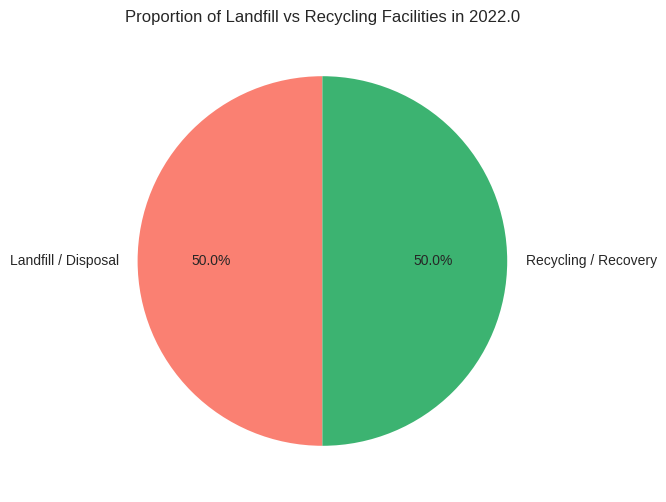

In [12]:
# === Visualization 3: Proportion of Landfill vs Recycling (2022) ===
latest_year = disposals_encoded[year_col].max()

latest_data = disposals_encoded[disposals_encoded[year_col] == latest_year]
landfill_count = latest_data[landfill_cols].count().values[0]
recycle_count  = latest_data[recycle_cols].count().values[0]

plt.figure(figsize=(6,6))
plt.pie(
    [landfill_count, recycle_count],
    labels=["Landfill / Disposal", "Recycling / Recovery"],
    autopct="%1.1f%%",
    colors=["salmon", "mediumseagreen"],
    startangle=90
)
plt.title(f"Proportion of Landfill vs Recycling Facilities in {latest_year}")
plt.show()


In [14]:
from google.colab import files

disposals_encoded.to_csv("cleaned_disposals.csv", index=False)
files.download("cleaned_disposals.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

releases_encoded.to_csv("cleaned_releases.csv", index=False)
files.download("cleaned_releases.csv")
